# Predicting Pumpkin Color
This challenge is part of the Machine Learning Course from Microsoft. The dataset includes 1757 lines of data about the market for pumpkins, sorted into groupings by city. This is raw data extracted from the Specialty Crops Terminal Markets Standard Reports distributed by the United States Department of Agriculture.  
We will use a logistic regression model to predict that, given some variables, what color a given pumpkin is likely to be orange 🎃 or white 👻. In logistic regression the variables don't have to align. That works for this data which has somewhat weak correlations.
For our purposes, we will express this as a binary: 'White' or 'Not White'. There is also a 'striped' category in our dataset but there are few instances of it, so we will not use it. It disappears once we remove null values from the dataset, anyway.

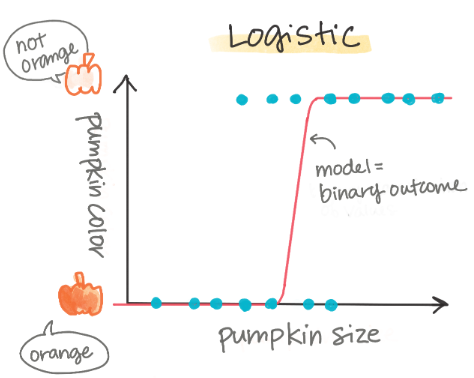

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error,f1_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression



In [ ]:
df = pd.read_csv("US-pumpkins.csv")
df.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [ ]:
#Select columns and drop null values

columns = ["City Name","Package","Variety","Origin","Item Size","Color"]

df = df.loc[:, columns]

df.dropna(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 2 to 1698
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   City Name  991 non-null    object
 1   Package    991 non-null    object
 2   Variety    991 non-null    object
 3   Origin     991 non-null    object
 4   Item Size  991 non-null    object
 5   Color      991 non-null    object
dtypes: object(6)
memory usage: 54.2+ KB


# Data pre-processing

The dataset contains string values for all its columns. Working with categorical data is intuitive for humans but not for machines. Machine learning algorithms work well with numbers. That's why encoding is a very important step in the data pre-processing phase, since it enables us to turn categorical data into numerical data, without losing any information. Good encoding leads to building a good model.




*Ordinal encoder:* It suits well for ordinal variables, which are categorical variables where their data follows a logical ordering, like the Item Size column in our dataset. It creates a mapping such that each category is represented by a number, which is the order of the category in the column.


In [ ]:
df['Item Size'].unique()

array(['med', 'lge', 'sml', 'xlge', 'med-lge', 'jbo', 'exjbo'],
      dtype=object)

In [ ]:
item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']

ordinal_encoder = OrdinalEncoder(categories = item_size_categories)

*Categorical encoder:* It suits well for nominal variables, which are categorical variables where their data does not follow a logical ordering, like all the features different from Item Size in our dataset. It is a one-hot encoding, which means that each category is represented by a binary column: the encoded variable is equal to 1 if the pumpkin belongs to that Variety and 0 otherwise.

In [ ]:
categorical_features = ['City Name', 'Package', 'Variety', 'Origin']

categorical_encoder = OneHotEncoder(sparse_output=False)

*ColumnTransformer*: Is used to combine multiple encoders into a single step and apply them to the appropriate columns.



In [ ]:
ct = ColumnTransformer(
    transformers=[('ord',ordinal_encoder,ordinal_features),
                  ('cat',categorical_encoder,categorical_features)])
ct.set_output(transform='pandas')

encoded_features = ct.fit_transform(df)

encoded_features.head()

,ord__Item Size,cat__City Name_ATLANTA,cat__City Name_BALTIMORE,cat__City Name_BOSTON,cat__City Name_CHICAGO,cat__City Name_COLUMBIA,cat__City Name_DALLAS,cat__City Name_DETROIT,cat__City Name_LOS ANGELES,cat__City Name_MIAMI,...,cat__Origin_MICHIGAN,cat__Origin_NEW JERSEY,cat__Origin_NEW YORK,cat__Origin_NORTH CAROLINA,cat__Origin_OHIO,cat__Origin_PENNSYLVANIA,cat__Origin_TENNESSEE,cat__Origin_TEXAS,cat__Origin_VERMONT,cat__Origin_VIRGINIA
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*LabelEncoder class*: Is a utility class to help normalize labels such that they contain only values between 0 and n_classes-1 (here, 0 and 1).

In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(df['Color'])

Merge the encoded features and label

In [ ]:
encoded_df = encoded_features.assign(Color = encoded_label)

encoded_df.head()

,ord__Item Size,cat__City Name_ATLANTA,cat__City Name_BALTIMORE,cat__City Name_BOSTON,cat__City Name_CHICAGO,cat__City Name_COLUMBIA,cat__City Name_DALLAS,cat__City Name_DETROIT,cat__City Name_LOS ANGELES,cat__City Name_MIAMI,...,cat__Origin_NEW JERSEY,cat__Origin_NEW YORK,cat__Origin_NORTH CAROLINA,cat__Origin_OHIO,cat__Origin_PENNSYLVANIA,cat__Origin_TENNESSEE,cat__Origin_TEXAS,cat__Origin_VERMONT,cat__Origin_VIRGINIA,Color
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#Mapping between the encoded and the originals values
list(label_encoder.inverse_transform([0,1]))

['ORANGE', 'WHITE']

# Exploration and Visualization

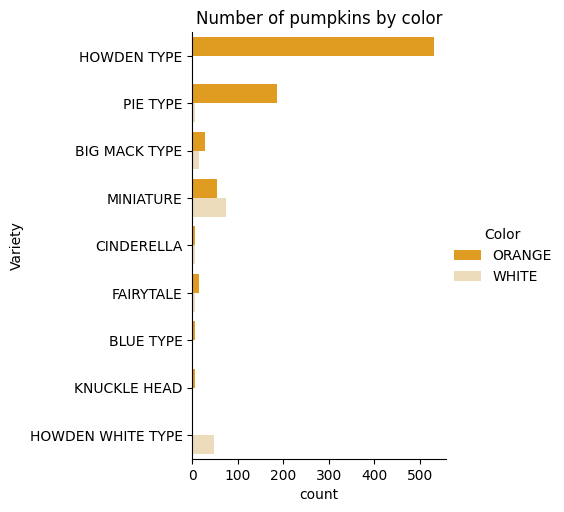

In [ ]:
palette = {
'ORANGE': 'orange',
'WHITE': 'wheat',
}

sns.catplot(data=df, y="Variety", hue="Color", kind="count", palette=palette, ).set(title="Number of pumpkins by color")


The graph reveals an imbalanced dataset, with a prevalence of orange observations and two specific pumpkin varieties. This will impact the model's performance in prediction.

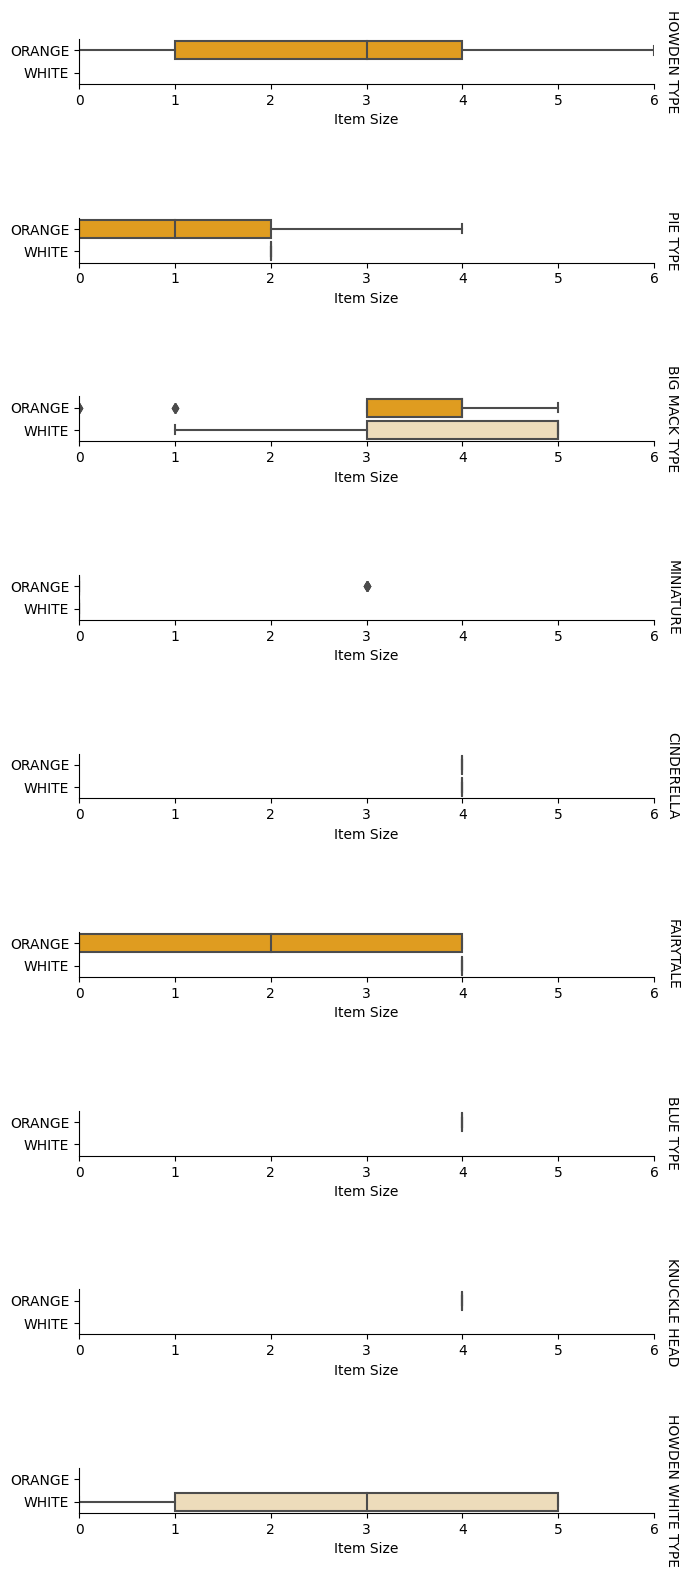

In [ ]:
df['Item Size'] = encoded_df['ord__Item Size']

g = sns.catplot(
        data=df,
        x="Item Size", y="Color", row='Variety',
        kind="box", orient="h",
        sharex=False, margin_titles=True,
        height=1.8, aspect=4, palette=palette,
    )
g.set(xlabel="Item Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")

<Axes: xlabel='Color', ylabel='Item Size'>

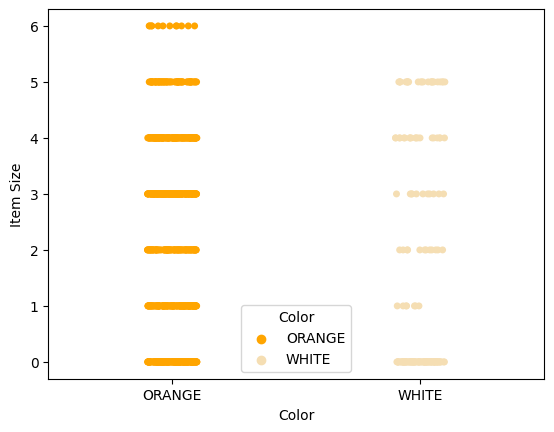

In [ ]:
sns.stripplot(data=df, x="Color", y="Item Size", hue="Color",palette = palette)


In [ ]:
X = encoded_df[encoded_df.columns.difference(['Color'])]
y = encoded_df['Color']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

model = LogisticRegression()

model.fit(X_train,y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('F1-score: ', f1_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       166
           1       0.85      0.67      0.75        33

    accuracy                           0.92       199
   macro avg       0.89      0.82      0.85       199
weighted avg       0.92      0.92      0.92       199

F1-score:  0.7457627118644068


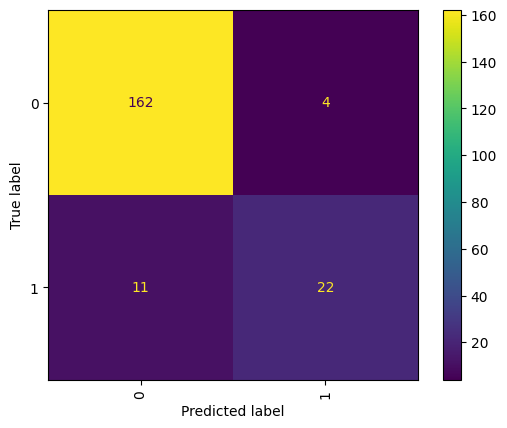

In [ ]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
cm_display.plot()

plt.xticks(rotation=90)
plt.show()

ROC curves are often used to get a view of the output of a classifier in terms of its true vs. false positives. Thus, the steepness of the curve and the space between the midpoint line and the curve matter: you want a curve that quickly heads up and over the line.

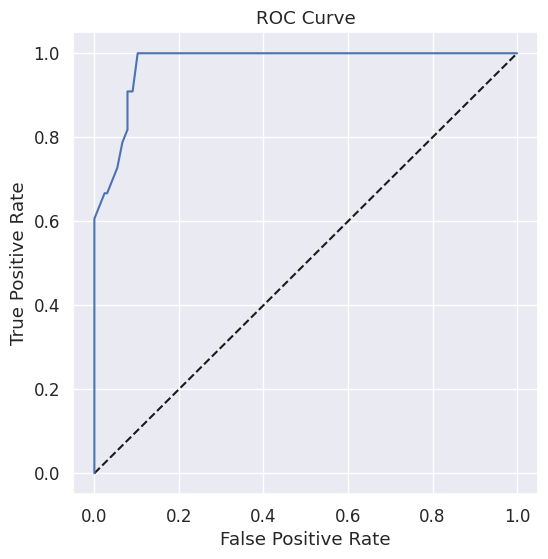

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

 In our case, there are false positives to start with, and then the line heads up and over properly. Our model is pretty close to the ideal one (A straight line starting in (0,0) and finishing in (0,1)).

In [ ]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

Given that the AUC ranges from 0 to 1, you want a big score, since a model that is 100% correct in its predictions will have an AUC of 1. In this case, the model is pretty good.